# Import Libraries

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Healthy Patients

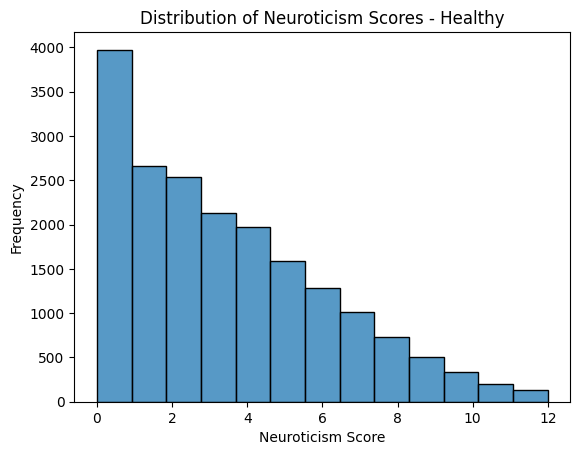

In [65]:
input_path = '/Users/baileyng/MIND_data/ukb_NEO/NEO_tabular_all_healthy.csv'
df = pd.read_csv(input_path, index_col=0)

# Histogram
sns.histplot(df['20127-0.0'], bins=13)
plt.title('Distribution of Neuroticism Scores - Healthy')
plt.xlabel('Neuroticism Score')
plt.ylabel('Frequency')
plt.show()

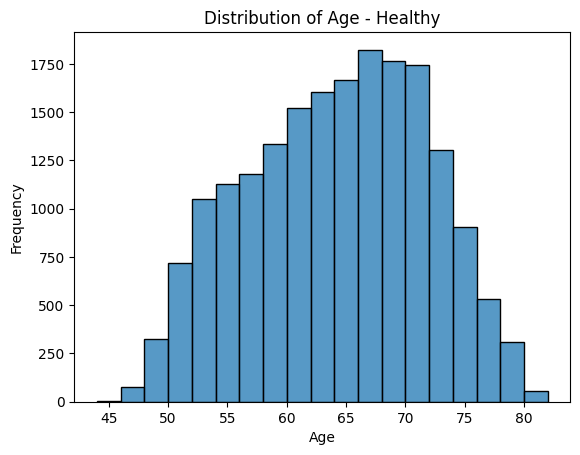

44 82


In [66]:
# Histogram
sns.histplot(df['21003-2.0'], bins=19)
plt.title('Distribution of Age - Healthy')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

print(min(df['21003-2.0']), max(df['21003-2.0']))

In [67]:
# load FC regions
with open('/Users/baileyng/MIND_models/FC_colnames.txt', 'r') as f:
    fc_regions = [line.strip() for line in f.readlines()]

rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

# rename columns
df = df.rename(columns=rename_dict)

In [68]:
# Process categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
centre_encoded = encoder.fit_transform(df[['assessment_centre']])

centre_feature_names = encoder.get_feature_names_out(['assessment_centre'])
centre_feature_names = [name.replace('assessment_centre_', 'centre_') for name in centre_feature_names]

centre_df = pd.DataFrame(centre_encoded, columns=centre_feature_names, index=df.index)
df = pd.concat([df, centre_df], axis=1)

#Get centre dummy column names
centre_cols = [col for col in df.columns if col.startswith('centre_')]

In [69]:
# Prepare base features
df['age_squared'] = df['age'] ** 2
df['age_sex_interaction'] = df['age'] * df['sex']

In [70]:
# Initialize storage for results
results = []

# Fit linear model for each FC region
for region in fc_regions:
    try:
        feature_cols = ['age', 'sex', 'age_sex_interaction', 'age_squared',
                        region, 'head_motion'] + centre_cols

        X = df[feature_cols]
        y = df['neuroticism_score']

        # Standardize features
        scaler = StandardScaler()
        dummy_cols = ['sex'] + centre_cols
        continuous_cols = [col for col in feature_cols if col not in dummy_cols]

        X_scaled = X.copy()
        X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

        X_scaled_w_const = sm.add_constant(X_scaled)

        # Fit linear regression model
        model = sm.OLS(y, X_scaled_w_const).fit()

        # Extract model statistics
        n_obs = model.nobs
        df_resid = model.df_resid
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
        rmse = np.sqrt(model.mse_resid)
        f_statistic = model.fvalue
        f_pvalue = model.f_pvalue

        # Store main results
        result = {
            'region_pair': region,
            'n_observations': int(n_obs),
            'df_residual': int(df_resid),
            'r_squared': r_squared,
            'adj_r_squared': adj_r_squared,
            'rmse': rmse,
            'f_statistic': f_statistic,
            'f_pvalue': f_pvalue
        }

        # Add coefficient statistics
        param_names = ['const'] + feature_cols

        for i, param in enumerate(param_names):

            if param == region:
                param_name = 'region_pair'
            else:
                param_name = param
                
            result[f'coef_{param_name}'] = model.params[i]
            result[f'se_{param_name}'] = model.bse[i]
            result[f'tstat_{param_name}'] = model.tvalues[i]
            result[f'pvalue_{param_name}'] = model.pvalues[i]

            # Confidence intervals
            conf_int = model.conf_int().iloc[i]
            result[f'ci_lower_{param_name}'] = conf_int[0]
            result[f'ci_upper_{param_name}'] = conf_int[1]

        results.append(result)

    except Exception as e:
        print(f"Error fitting model for {region}: {e}")
        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"\nSuccessfully fitted models for {len(results_df)} regions")
print(f"Results shape: {results_df.shape}")



Successfully fitted models for 210 regions
Results shape: (210, 62)


In [71]:
# Save results to CSV files
output_dir = '/Users/baileyng/MIND_data/ukb_NEO/'

# Save complete results
results_df.to_csv(f'{output_dir}NEO_lm_results_healthy.csv', index=False)

print("Saved file!")

Saved file!


In [72]:
# Calculate and save descriptive statistics
descriptive_stats = {}

descriptive_stats['n'] = df['age'].count()

# Means and standard deviations for continuous variables
continuous_vars = ['neuroticism_score', 'age', 'head_motion']
for var in continuous_vars:
    descriptive_stats[f'{var}_mean'] = df[var].mean()
    descriptive_stats[f'{var}_std'] = df[var].std()

# Percentages for categorical variables
categorical_vars = ['sex', 'assessment_centre']
for var in categorical_vars:
    value_counts = df[var].value_counts()
    percentages = df[var].value_counts(normalize=True) * 100
    
    for category in value_counts.index:
        descriptive_stats[f'{var}_{category}_count'] = value_counts[category]
        descriptive_stats[f'{var}_{category}_percent'] = percentages[category]

# Convert to DataFrame and save
descriptive_df = pd.DataFrame([descriptive_stats])
descriptive_df.to_csv(f'{output_dir}NEO_summary_stats_healthy.csv', index=False)

# MDD Patients

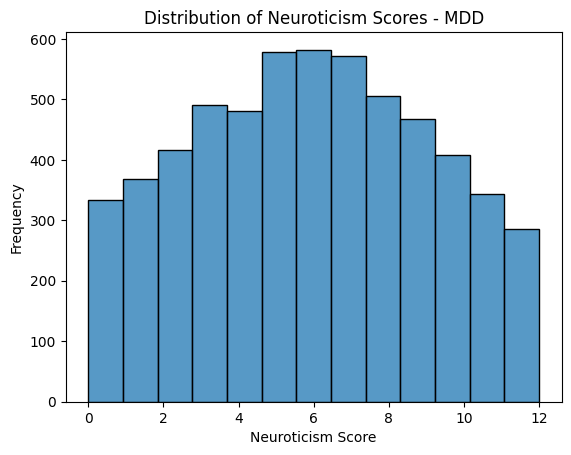

In [73]:
input_path = '/Users/baileyng/MIND_data/ukb_NEO/NEO_tabular_all_MDD.csv'
df = pd.read_csv(input_path, index_col=0)

# Histogram
sns.histplot(df['20127-0.0'], bins=13)
plt.title('Distribution of Neuroticism Scores - MDD')
plt.xlabel('Neuroticism Score')
plt.ylabel('Frequency')
plt.show()

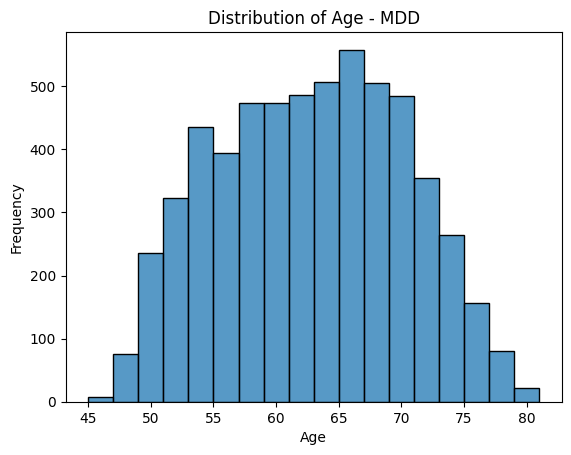

45 81


In [74]:
# Histogram
sns.histplot(df['21003-2.0'], bins=18)
plt.title('Distribution of Age - MDD')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

print(min(df['21003-2.0']), max(df['21003-2.0']))

In [75]:
# load FC regions
with open('/Users/baileyng/MIND_models/FC_colnames.txt', 'r') as f:
    fc_regions = [line.strip() for line in f.readlines()]

rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

# rename columns
df = df.rename(columns=rename_dict)

In [76]:
# Process categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
centre_encoded = encoder.fit_transform(df[['assessment_centre']])

centre_feature_names = encoder.get_feature_names_out(['assessment_centre'])
centre_feature_names = [name.replace('assessment_centre_', 'centre_') for name in centre_feature_names]

centre_df = pd.DataFrame(centre_encoded, columns=centre_feature_names, index=df.index)
df = pd.concat([df, centre_df], axis=1)

#Get centre dummy column names
centre_cols = [col for col in df.columns if col.startswith('centre_')]

In [77]:
# Prepare base features
df['age_squared'] = df['age'] ** 2
df['age_sex_interaction'] = df['age'] * df['sex']

In [78]:
# Initialize storage for results
results = []

# Fit linear model for each FC region
for region in fc_regions:
    try:
        feature_cols = ['age', 'sex', 'age_sex_interaction', 'age_squared',
                        region, 'head_motion'] + centre_cols

        X = df[feature_cols]
        y = df['neuroticism_score']

        # Standardize features
        scaler = StandardScaler()
        dummy_cols = ['sex'] + centre_cols
        continuous_cols = [col for col in feature_cols if col not in dummy_cols]

        X_scaled = X.copy()
        X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

        X_scaled_w_const = sm.add_constant(X_scaled)

        # Fit linear regression model
        model = sm.OLS(y, X_scaled_w_const).fit()

        # Extract model statistics
        n_obs = model.nobs
        df_resid = model.df_resid
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
        rmse = np.sqrt(model.mse_resid)
        f_statistic = model.fvalue
        f_pvalue = model.f_pvalue

        # Store main results
        result = {
            'region_pair': region,
            'n_observations': int(n_obs),
            'df_residual': int(df_resid),
            'r_squared': r_squared,
            'adj_r_squared': adj_r_squared,
            'rmse': rmse,
            'f_statistic': f_statistic,
            'f_pvalue': f_pvalue
        }

        # Add coefficient statistics
        param_names = ['const'] + feature_cols

        for i, param in enumerate(param_names):

            if param == region:
                param_name = 'region_pair'
            else:
                param_name = param
                
            result[f'coef_{param_name}'] = model.params[i]
            result[f'se_{param_name}'] = model.bse[i]
            result[f'tstat_{param_name}'] = model.tvalues[i]
            result[f'pvalue_{param_name}'] = model.pvalues[i]

            # Confidence intervals
            conf_int = model.conf_int().iloc[i]
            result[f'ci_lower_{param_name}'] = conf_int[0]
            result[f'ci_upper_{param_name}'] = conf_int[1]

        results.append(result)

    except Exception as e:
        print(f"Error fitting model for {region}: {e}")
        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"\nSuccessfully fitted models for {len(results_df)} regions")
print(f"Results shape: {results_df.shape}")



Successfully fitted models for 210 regions
Results shape: (210, 62)


In [79]:
# Save results to CSV files
output_dir = '/Users/baileyng/MIND_data/ukb_NEO/'

# Save complete results
results_df.to_csv(f'{output_dir}NEO_lm_results_MDD.csv', index=False)

print("Saved file!")

Saved file!


In [80]:
# Calculate and save descriptive statistics
descriptive_stats = {}

descriptive_stats['n'] = df['age'].count()

# Means and standard deviations for continuous variables
continuous_vars = ['neuroticism_score', 'age', 'head_motion']
for var in continuous_vars:
    descriptive_stats[f'{var}_mean'] = df[var].mean()
    descriptive_stats[f'{var}_std'] = df[var].std()

# Percentages for categorical variables
categorical_vars = ['sex', 'assessment_centre']
for var in categorical_vars:
    value_counts = df[var].value_counts()
    percentages = df[var].value_counts(normalize=True) * 100
    
    for category in value_counts.index:
        descriptive_stats[f'{var}_{category}_count'] = value_counts[category]
        descriptive_stats[f'{var}_{category}_percent'] = percentages[category]

# Convert to DataFrame and save
descriptive_df = pd.DataFrame([descriptive_stats])
descriptive_df.to_csv(f'{output_dir}NEO_summary_stats_MDD.csv', index=False)